<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch3_6_pg_175~182.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **06 피마 인디언 당뇨병 예측**

---

피마 인디언 당뇨병(Pima Indian Diabetes) 데이터 세트를 이용해 당뇨병 여부를 판단하는 머신러닝 예측 모델 수립

북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터.

20세기 후반되며 서구화된 식습관으로 많은 당뇨환자 생김

Pregnancies: 임신 횟수

Glucose: 포도당 부하 검사 수치

BloodPressure: 혈압

SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)

Insulin: 혈청 인슐린(mu U/ml)

BMI: 체질량지수(체중(kg)/(키(m))^2)

DiabetesPedigreeFunction: 당뇨 내력 가중치 값

Age: 나이

Outcome: 클래스 결정 값(0 또는 1)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


->Negative(0)이 500개, Positive(1)이 268개로 Negative가 상대적으로 많음

In [3]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


->Null값은 없고 모두 숫자형.

In [9]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test,pred)

  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy,precision, recall, f1, roc_auc))

In [10]:
#피처 데이터 세트 X, 레입르 데이터 세트 y를 추출
#맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

#로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,pred,pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741,F1: 0.6392, AUC:0.7919


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


전체 데이터의 64%가 Negative이므로 정확도보다는 재현율 성능에 초점 맞춰보기

먼저 정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화 확인하기

-precision_recall_curve_plot() 함수 이용

In [12]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--',label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  #threshold 값 X 축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))

  # x축, y축 label과 legend, 그리고 grid 설정
  plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

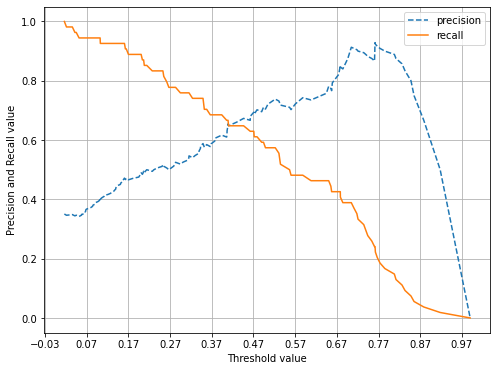

In [13]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test,pred_proba_c1)

임곗값이 약 0.42 정도면 균형

하짐나 두 개의 지표 모두 0.7이 안되는 수치(값이 여전히 낮음)

->임곗값을 인위적으로 조작하기 전에 다시 데이터 값 점검해보기

In [14]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min값이 0으로 되어있는 피처가 상당히 많음

Glucose 피처는 포도당 수치인데 min값이 0인건 불가

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

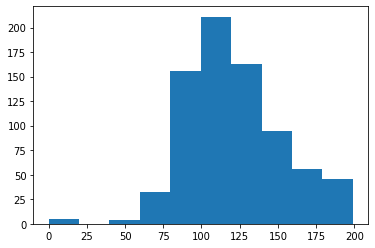

In [16]:
plt.hist(diabetes_data['Glucose'], bins=10)

-0 값이 일정 수준 존재한다는 것을 확인 가능

->min() 값이 0으로 되어있는 피처에 대해 0값의 건수 및 전체 데이터 건수 대비 몇퍼센트의 비율로 존재하는지 확인

Glucose, BloodPressure, SkinThickness, Insulin, BMI 확인

In [18]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고 퍼센트 계산
for feature in zero_features:
  zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
  print('{0} 0 건수는 {1}, 퍼센트는 {2: .2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는  0.65 %
BloodPressure 0 건수는 35, 퍼센트는  4.56 %
SkinThickness 0 건수는 227, 퍼센트는  29.56 %
Insulin 0 건수는 374, 퍼센트는  48.70 %
BMI 0 건수는 11, 퍼센트는  1.43 %


->SkinThickness와 Insulin의 0 값은 각각 전체의 29.56%, 48.7%로 매우 많음

위 피처의 0값을 평균값으로 대체

In [30]:
#zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0,mean_zero_features)

0 값을 평균값으로 대체한 데이터 세트에 피처 스케일링을 적용해 변환하기.

로지스틱 회귀는 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋다.->스케일링 먼저 하고 다시 학습/테스트 데이터 세트로 나눈 후 로지스틱 회귀를 적용해 성능 평가 지표 확인

In [31]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

#StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify = y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,F1: 0.6804, AUC:0.8433


->데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선됨

(로지스틱 회귀 제대로 안배웠으니 하이퍼 파라미터에 대한 튜닝은 생략)

여전히 재현율 수치는 개선이 필요해보임

분류 결정 임곗값을 변화시키며 재현율 값의 성능 수치가 어느정도 개선되는지 확인해보기

In [40]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('\n임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [41]:
#임곗값을 0.3에서 0.5까지 0.03씩 변화시키며 재현율과 다른 평가 지표의 값 변화 출력
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,F1: 0.6615, AUC:0.8433

임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,F1: 0.6774, AUC:0.8433

임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,F1: 0.6667, AUC:0.8433

임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,F1: 0.6667, AUC:0.8433

임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,F1: 0.6792, AUC:0.8433

임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,F1: 0.6857, AUC:0.8433

임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,F1: 0.6931, AUC:0.8433

임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,F1: 0.6804, AUC:0.8433


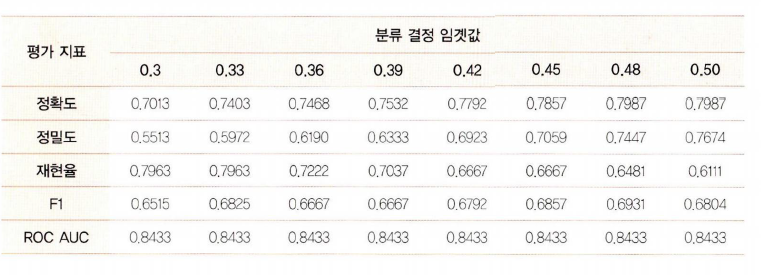

가장 좋은 임곗값:0.33, 재현율 값: 0.7963. 하지만 정밀도가 매우 저조(극단적 선택)

임곗값 0.48이 가장 적절

In [43]:
#임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

#위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test,pred_th_048,pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,F1: 0.6931, AUC:0.8433
